In [1]:
import torch
import sys
import pyro
import pyro.distributions as dist

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

import numpy as np

from pooledQTL import deconvolve, beta_model, gaussian_model, io_utils, asb_data, pyro_utils

from importlib import reload

from pathlib import Path

fdr_threshold = 0.05
device = "cuda:0" if torch.cuda.is_available() else "cpu"
use_structured_guide = True # performs much better

results_dir = Path("/gpfs/commons/home/daknowles/pooledRBPs/results/HNRNPK")

/gpfs/commons/home/daknowles/.conda/envs/asb/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
merged = { 
    rep_index:pd.read_csv(
        results_dir / ("merged_rep%i.tsv.gz" % rep_index), 
        index_col = False, 
        sep = "\t" )
    for rep_index in range(2) }

dat_sub = { 
    rep_index:pd.read_csv(
        results_dir / ("filtered_rep%i.tsv.gz" % rep_index), 
        index_col = False, 
        sep = "\t" )
    for rep_index in range(2) }

In [5]:
df_cat = pd.concat( dat_sub, axis = 0)
data = asb_data.ReplicateASBdata.from_pandas(df_cat)


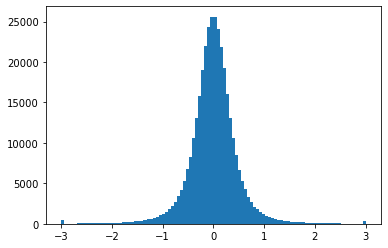

In [159]:
ase = dist.StudentT(3., 0., 0.3).sample([data.num_snps]).clamp(-3.,3.)
asb = dist.StudentT(3., 0., 0.3).sample([data.num_snps]).clamp(-3.,3.)
_ = plt.hist(asb.numpy(), 100)

In [160]:
input_count_conc = 100. 
IP_count_conc = 100. 

input_ratio = torch.logit(data.pred_ratio) + ase[data.snp_indices]
input_alt = pyro.sample( 
    "input_alt", 
    pyro_utils.BetaBinomialReparam(
        torch.sigmoid(input_ratio), 
        input_count_conc,
        total_count = data.input_total_count, 
        eps = 1.0e-8))
IP_alt = pyro.sample( 
    "IP_alt",
    pyro_utils.BetaBinomialReparam(
        torch.sigmoid(input_ratio + asb[data.snp_indices]),
        IP_count_conc,
        total_count = data.IP_total_count,
        eps = 1.0e-8))

Text(0, 0.5, 'Proportion alternate allele in RNA')

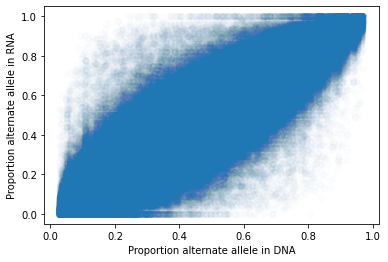

In [161]:
plt.scatter( data.pred_ratio.numpy(), (input_alt / data.input_total_count).numpy(), alpha = 0.01)
plt.xlabel("Proportion alternate allele in DNA")
plt.ylabel("Proportion alternate allele in RNA")

Text(0, 0.5, 'Proportion alternate allele in IP')

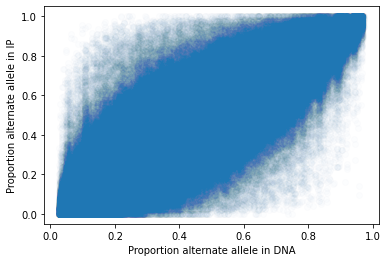

In [162]:
plt.scatter( data.pred_ratio.numpy(), (IP_alt / data.IP_total_count).numpy(), alpha = 0.01)
plt.xlabel("Proportion alternate allele in DNA")
plt.ylabel("Proportion alternate allele in IP")

In [163]:
import dataclasses
data_sim = dataclasses.replace(data, input_alt_count = input_alt, IP_alt_count = IP_alt)

In [164]:
reload(gaussian_model)

losses, model, guide, stats, samples, results, shrunk, fit_hypers = gaussian_model.fit(
    data_sim, 
    learn_t_dof = True, 
    Laplace = False,
    studentT = True,
    use_structured_guide = True,
    num_samples = 100,
    iterations = 1000)

In [165]:
fit_hypers

{'ase_scale': 0.33076515793800354,
 'input_count_conc': 98.2804183959961,
 'asb_scale': 0.38091880083084106,
 'IP_count_conc': 80.22802734375,
 'ase_t_df': 3.7374050617218018,
 'asb_t_df': 5.256556034088135}

In [166]:
mc_std = 

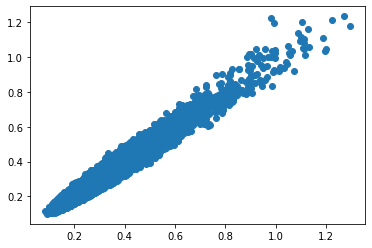

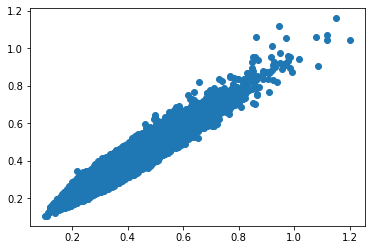

In [169]:
plt.scatter( samples["ase"].std([0,1]),  results.ase_sd ); plt.show() # good agreement
plt.scatter( samples["asb"].std([0,1]),  results.asb_sd ) # good agreement

(0.8647094210256757, 0.0)

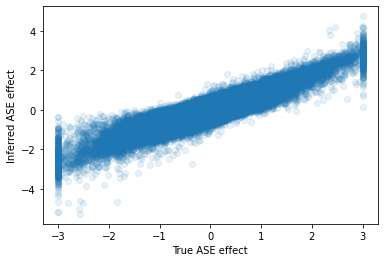

In [177]:
plt.scatter( ase.numpy(), results.ase_loc, alpha=0.1)
plt.xlabel("True ASE effect")
plt.ylabel("Inferred ASE effect")
scipy.stats.pearsonr( ase.numpy(), results.ase_loc )

(0.7776494603124546, 0.0)

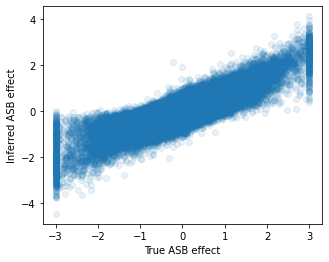

In [176]:
plt.figure(figsize = (5,4))
plt.scatter( asb.numpy(), results.asb_loc, alpha=0.1)
plt.xlabel("True ASB effect")
plt.ylabel("Inferred ASB effect")
scipy.stats.pearsonr( asb.numpy(), results.asb_loc )

(0.7776494603124546, 0.0)

Text(0, 0.5, 'Inferred ASB effect')

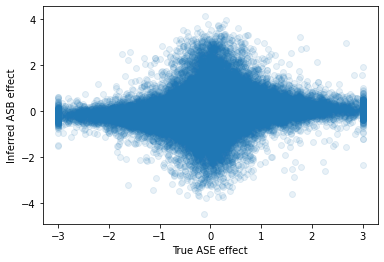

In [173]:
plt.scatter( ase.numpy(), results.asb_loc, alpha=0.1)
plt.xlabel("True ASE effect")
plt.ylabel("Inferred ASB effect")

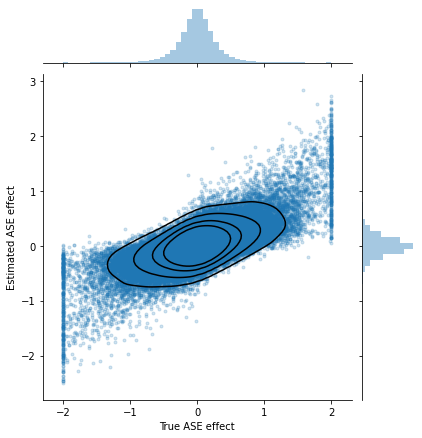

In [105]:
c = (sns.jointplot(
    asb.numpy(), 
    results.asb_loc, 
    marker='.',
    alpha=0.2
).plot_joint(
    sns.kdeplot, 
    levels=[0.01, 0.05, 0.2, 0.5],
    bw = 0.1,
    colors = "black"
)).set_axis_labels('True ASE effect', 'Estimated ASE effect')

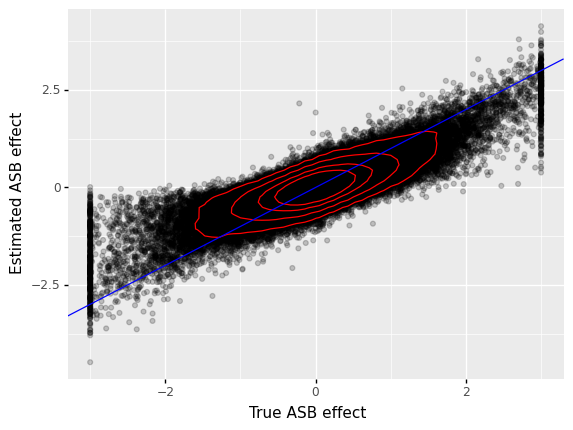

<ggplot: (8775438887217)>

In [178]:
import plotnine as p9
(p9.ggplot(p9.aes(x = asb.numpy(), y = results.asb_loc )) + 
 p9.geom_point(alpha=0.2) + 
 p9.geom_density_2d(color = "red", levels = [0.01, 0.05, 0.2, 0.5]) +
 p9.geom_abline(intercept=0, slope=1, color = "blue") +
 p9.xlab("True ASB effect") + 
 p9.ylab("Estimated ASB effect"))

In [179]:
merged_reps = dat_sub[0].merge(
    dat_sub[1],
    "outer", 
    on = ['contig', 'position', 'position_hg19', 'variantID', 'refAllele', 'altAllele'],
    suffixes=["_1","_2"]
).fillna(0, downcast='infer').merge(results, on = "variantID")

merged_reps["input_totalTotal"] = merged_reps.totalCount_input_1 + merged_reps.totalCount_input_2
merged_reps["IP_totalTotal"] = merged_reps.totalCount_IP_1 + merged_reps.totalCount_IP_2

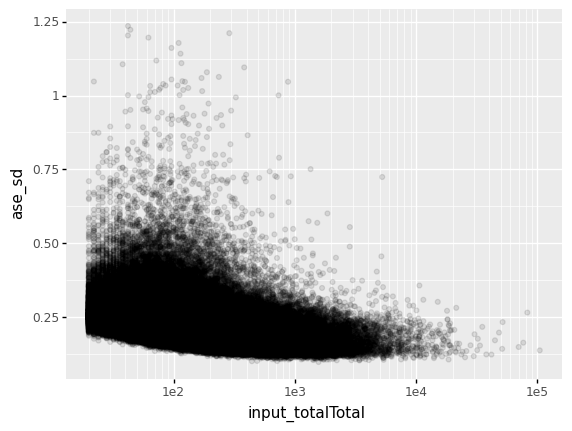

<ggplot: (8775476379510)>

In [183]:
p9.ggplot(merged_reps, p9.aes(x = "input_totalTotal", y = "ase_sd")) + p9.geom_point(alpha=0.1) + p9.scale_x_log10()

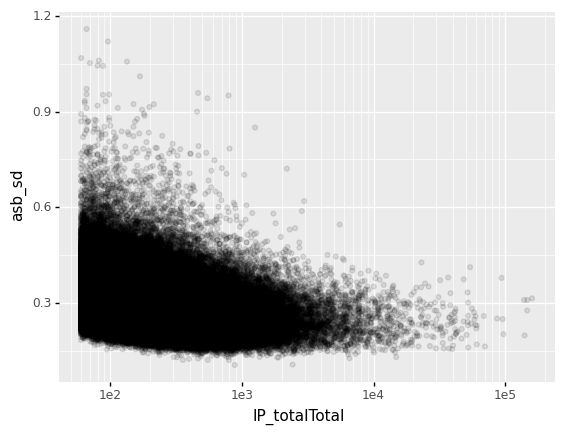

<ggplot: (8775482497970)>

In [184]:
p9.ggplot(merged_reps, p9.aes(x = "IP_totalTotal", y = "asb_sd")) + p9.geom_point(alpha=0.1) + p9.scale_x_log10()

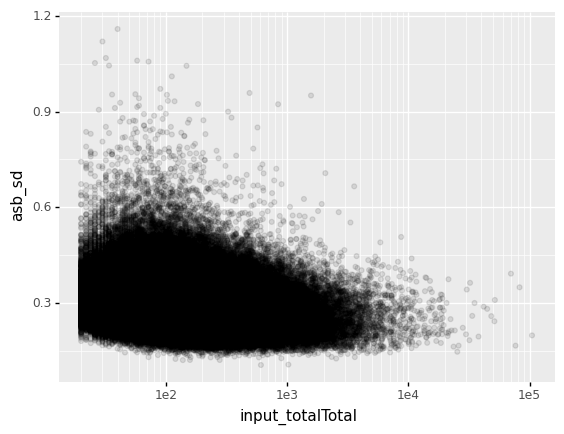

<ggplot: (8775482571882)>

In [185]:
p9.ggplot(merged_reps, p9.aes(x = "input_totalTotal", y = "asb_sd")) + p9.geom_point(alpha=0.1) + p9.scale_x_log10()

In [85]:
sns.kdeplot(x=ase.numpy(), y=results.asb_loc)

TypeError: kdeplot() missing 1 required positional argument: 'data'